### (Seq2Seq) LSTM-based CVAE Autoencoder: using dataset of trajectories, predict trajectories
# Created by: Eley Ng
# Modified by: Junwu Zhang
# Stanford ARM-Lab

In [1]:
%matplotlib inline
import torch
import random
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import copy
from torch.autograd import Variable
import seaborn as sns
from sklearn.model_selection import train_test_split
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
from platform import python_version

## Generate Data

In [2]:
#####################
# Dataset generation
#####################
np.random.seed(seed=123) 

Ti = 0
Tf = 10
seg = 5 # length of trajectory observation / length of prediction (assume same length for now)
samples = 100
features = 2 # x,y

samp_freq = samples/(Tf-Ti)

t = np.linspace(Ti, Tf, num=samples+2*seg)

x = 2*t
y = 2*np.cos(t)

# Note: shape input into [samples, timesteps, features] to use with Pytorch data loader (future use)
data_in = np.zeros((samples, seg, features)) # data_in:= input trajectory
data_gt = np.zeros((samples, seg, features)) # data_gt:= target prediction trajectories

# Generate data (with option to add noise)
for i in range(samples):
    
    data_in[i,:,0] = x[i:i+seg] #+ np.random.normal(mean, cov)
    data_in[i,:,1] = y[i:i+seg] #+ np.random.normal(mean, cov)
    
    data_gt[i,:,0] = x[i+seg:i+seg*2] #+ np.random.normal(mean, cov)
    data_gt[i,:,1] = y[i+seg:i+seg*2] #+ np.random.normal(mean, cov)

# Printouts    
print('99th sample dim: ', data_in[99,:,:])
print("Sampling frequency", samp_freq)

99th sample dim:  [[18.16513761 -1.88403128]
 [18.34862385 -1.93759404]
 [18.53211009 -1.97485988]
 [18.71559633 -1.99551538]
 [18.89908257 -1.99938681]]
Sampling frequency 10.0


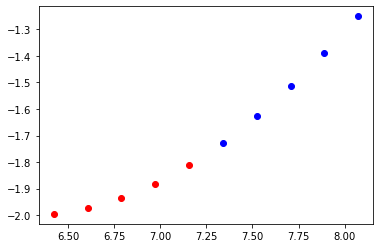

In [3]:
#####################
# Plot some data
#####################
s = 35

plt.plot(data_gt[s,:,0], data_gt[s,:,1], 'o', color='b') # Dataset
plt.plot(data_in[s,:,0], data_in[s,:,1], 'o', color='r') # Dataset
# plt.plot(x,y) # Real trajectory

## Create Model

In [4]:
### Encoder: 2 LSTMs, 
#   Input: batch size, sequence length, feature size, condition size, embedding dimension 
#   Output: mean and variance for latent space distribution
### The encoder first concatenates the input trajectory with the specified CVAE conditions. 
#   Then it uses 2 LSTM layers to encode the input trajectories and the conditions, 
#   as well as 2 linear layers to generate mean and variance of the latent distribution
#   based on the last hidden state for each sample in the batch.

class Encoder(nn.Module):
    def __init__(self, batch_size, seq_len, n_features, n_conditions=1, embedding_dim=16):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features, self.n_conditions = seq_len, n_features, n_conditions
        self.batch_size = batch_size
        self.embedding_dim, self.hidden_dim = embedding_dim, 2*embedding_dim
        self.lstm1 = nn.LSTM(
          input_size=n_features + n_conditions,
          hidden_size=self.hidden_dim,
          num_layers=1, #not stacked lstm here but could be, except we decided to expand the hidden dim (to twice the size)
          batch_first=True # for pytorch. thankfully, our input is shaped as (batch, seq, feature) 
        )
        self.lstm2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim, 
          num_layers=1,
          batch_first=True
        )
        self.fc1 = nn.Linear(embedding_dim, 16)
        self.fc2 = nn.Linear(embedding_dim, 16)
    def forward(self, x, c):
        inputs = torch.cat([x, c], 2)    # 10, 5, 3
        x = inputs.reshape((self.batch_size, self.seq_len, self.n_features + self.n_conditions))
        x, (hidden_n, _) = self.lstm1(x)
        x, (hidden_n, _) = self.lstm2(x)
        z_mu = self.fc1(hidden_n)
        z_var = self.fc2(hidden_n)
        return z_mu, z_var

In [5]:
### Decoder: 2 LSTMs, input: last hidden state for each batch; output: the trajectory prediction for each batch
### Decoder: 2 LSTMs, 
#   Input: batch size, prediction length, feature size, condition size, input dimension 
#   Output: the trajectory prediction for each batch
### The decoder first concatenates the reparameterization of latent space mean and variance. 
#   Then it uses 2 LSTM layers to decode the input into predicted trajectories, 
#   as well as a linear layer to reshape the output to the desired dimensions.

class Decoder(nn.Module):
    def __init__(self, batch_size, pred_len, n_conditions=1, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.pred_len, self.input_dim = pred_len, input_dim #input dim is embedding dim from encoder
        self.batch_size = batch_size
        self.hidden_dim, self.n_features = input_dim, 4* n_features #2 * input_dim, n_features
        self.lstm1 = nn.LSTM(
          input_size=input_dim + n_conditions,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.lstm2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features) # use output layer to reshape to the desired number of features
   
    def forward(self, z, c):       
        dim0 = z.shape[0]
        dim1 = z.shape[1]
        z = z.reshape(dim1, -1, 16)
        z = z.repeat(1, self.pred_len, 1)
        x = torch.cat([z, c], 2)
        x, (hidden_n, cell_n) = self.lstm1(x)
        x, (hidden_n, cell_n) = self.lstm2(x)
        x = x.reshape((self.batch_size, self.pred_len, self.hidden_dim))        

        return self.output_layer(x)

In [6]:
class CVAEAutoencoder(nn.Module):
    def __init__(self, batch_size, seq_len, pred_len, n_features, n_conditions, embedding_dim=64):
        super(CVAEAutoencoder, self).__init__()
        self.encoder = Encoder(batch_size, seq_len, n_features, n_conditions, embedding_dim).to(device)
        self.decoder = Decoder(batch_size, pred_len, n_conditions, embedding_dim, n_features).to(device)
        self.batch_size = batch_size
    
    # Reparameterization trick        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        x = self.decoder(z, c)
        return x, mu, logvar

In [7]:
def make_batches(train_data, batch_size): 
    # Suggestion: randomize samples in batches
    batched_in = []
    batched_gt = []
    train_in, train_gt = train_data[0], train_data[1]
    N = train_in.shape[0]
    for i in range ( N // batch_size ):
        batched_in.append(train_in[i*batch_size:(i+1)*batch_size])
        batched_gt.append(train_gt[i*batch_size:(i+1)*batch_size])
    return batched_in, batched_gt

In [8]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.l1_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [9]:
def train_model(model, train_dataset, val_dataset, n_epochs, batch_sz=10):
    
    train_in, train_gt = make_batches(train_dataset, batch_size)
    val_in, val_gt = make_batches(val_dataset, batch_size)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict()) # keep best model; use deep copy for modules, clone for tensors
    best_loss = 10000.0
    
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_losses = []
        
        #batch training
        for i in range(len(train_in)):
            observations = train_in[i] # input a batch of training sequences, from t0 to t
            seq_true = train_gt[i] # target prediction sequences, from t+1 to tH
            # in this example, conditions are chosen to be the y values of each training point
            conditions = observations[:,:,[1]]  
            optimizer.zero_grad()
            seq_pred, mu, logvar = model(observations, conditions)
            loss = loss_function(seq_pred, seq_true, mu, logvar)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
        
            #batch evaluation
            for i in range(len(val_in)):
                observations = val_in[i]
                seq_true = val_gt[i] # EV: u had train here earlier whihc im p sure was a big bug
                observations = observations.to(device)
                seq_true = seq_true.to(device)
                conditions = observations[:,:,[1]]
                seq_pred, mu, logvar = model(observations, conditions) # use model to predict
                loss = loss_function(seq_pred, seq_true, mu, logvar)
                val_losses.append(loss.item())
            
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        
    model.load_state_dict(best_model_wts)
    return model.eval(), history

## Training
Define model by specifying model parameters, training hyperparameters, and splitting dataset into training and validation sets

In [10]:
#sample number, timesteps, num_features
num_samples = data_in.shape[0]
seq_len = data_in.shape[1]
n_features = data_in.shape[2]
n_conditions = 1

#network parameters
embedding_dim = 16

# hyperparameters
pred_len = data_gt.shape[1]
batch_size = 10
num_epochs = 2500

#data split
ptrain = 0.8
numtrain = int(ptrain*num_samples)

print('Embedding_dim: ', embedding_dim, '\nSamples per batch (batch size): ', batch_size, '\nNumber of epochs: ', num_epochs)

# Split data into training and validation
idx = np.random.permutation(samples)

train_idx = idx[:numtrain]
val_idx = idx[numtrain:]

train_in = data_in[train_idx, :,:]
train_gt = data_gt[train_idx, :,:]
val_in = data_in[val_idx,:,:]
val_gt = data_gt[val_idx,:,:]

print('Sizes: training input, validation input, training output, validation output')
print(train_in.shape, val_in.shape, train_gt.shape, val_gt.shape)

train_in = torch.Tensor(train_in).float()
val_in = torch.Tensor(val_in).float()

train_gt = torch.Tensor(train_gt).float()
val_gt = torch.Tensor(val_gt).float()

# Create model
model = CVAEAutoencoder(batch_size, seq_len, pred_len, n_features, n_conditions, embedding_dim)
model = model.to(device)

Embedding_dim:  16 
Samples per batch (batch size):  10 
Number of epochs:  2500
Sizes: training input, validation input, training output, validation output
(80, 5, 2) (20, 5, 2) (80, 5, 2) (20, 5, 2)


In [11]:
train = (train_in, train_gt)
val = (val_in, val_gt)

model, history = train_model(
    model,
    train,
    val,
    n_epochs=num_epochs,
    batch_sz=batch_size
)

Epoch 1: train loss 569.0904808044434 val loss 663.2662048339844
Epoch 2: train loss 566.5351753234863 val loss 660.3724670410156
Epoch 3: train loss 563.2865905761719 val loss 657.509765625
Epoch 4: train loss 560.4912185668945 val loss 655.8386840820312
Epoch 5: train loss 557.963794708252 val loss 652.2897338867188
Epoch 6: train loss 554.3486175537109 val loss 649.2391357421875
Epoch 7: train loss 551.1253395080566 val loss 645.2546997070312
Epoch 8: train loss 546.5955581665039 val loss 639.9865112304688
Epoch 9: train loss 539.9219970703125 val loss 632.0356140136719
Epoch 10: train loss 532.3205184936523 val loss 624.3681335449219
Epoch 11: train loss 523.5226898193359 val loss 611.2137756347656
Epoch 12: train loss 508.1919746398926 val loss 601.0218811035156
Epoch 13: train loss 495.3960189819336 val loss 585.1578979492188
Epoch 14: train loss 481.08595275878906 val loss 572.7757568359375
Epoch 15: train loss 464.51776123046875 val loss 557.0778198242188
Epoch 16: train loss 4

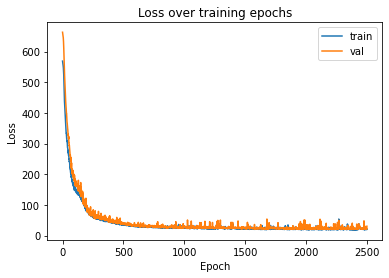

In [12]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show();

## Inference
This inference is performed on the validation set. You can supply your own test set by generating more data.

In [13]:
def predict(model, dataset):
    predictions, losses = [], []
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset: #seq_len x feature
            seq_true = seq_true.to(device)
            seq_true = torch.unsqueeze(seq_true, 0)
            conditions = seq_true[:,:,[1]]
            seq_pred, mu, logvar = model(seq_true, conditions)
            loss = loss_function(seq_pred, seq_true, mu, logvar)

            predictions.append(seq_pred.cpu().numpy())
            losses.append(loss.item())
            
    return predictions, losses

In [14]:
test_model = CVAEAutoencoder(1, seq_len, pred_len, n_features, n_conditions, embedding_dim) #batchsz, seq_len, n_features, embedding dim
test_model = test_model.to(device)
test_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [15]:
def plot_prediction(data, target, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    ax.plot(data[:,0], data[:,1], 'bo', label='true_hist')
    ax.plot(target[:,0], target[:,1], 'go', label='true_future')
    pred = np.reshape(np.array(predictions[0]), (-1,2))
    ax.plot(pred[:,0], pred[:,1], 'ro', label='model_pred')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    print(pred_losses[0])
    ax.legend()

8.374588966369629
8.590381622314453
9.548521041870117
10.631052017211914


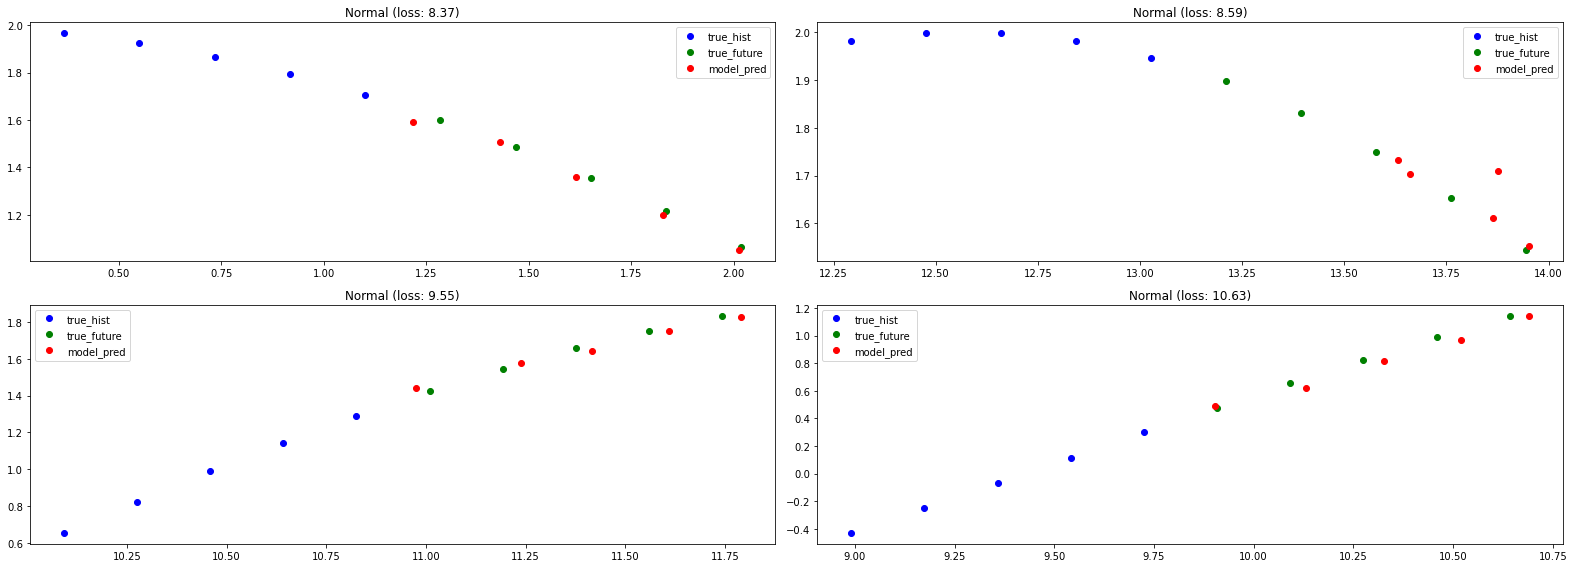

In [17]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=2,
  sharey=False,
  sharex=False,
  figsize=(22, 8)
)

for i,data in enumerate(val_in[:2]):
    for j,data in enumerate(val_in[2:4]):
        plot_prediction(val_in[:4][j+2*i], val_gt[:4][j+2*i], test_model, title='Normal', ax=axs[i,j])

fig.tight_layout();

Try playing around with the model now! Mess with the model hyperparameters, model parameters, and parameters in the dataset.